# XGBoost regression для предсказания рыночной (выставляемой) стоимости квартиры

In [46]:
import sys
### установка библиотеки xgboost
!{sys.executable} -m pip install xgboost

In [47]:
import pandas as pd
import numpy as np
import xgboost as xg
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from IPython.display import Image

Импортируем датасет с сырыми данными лотов недвижимости, выставленных на одном из агрегаторов объявлений. Сразу удалим дубликаты и почистим пропуски.

In [48]:
data = pd.read_csv('realty.csv', sep=';',
                   encoding='cp1251',
                   header=None,
                   names=['price','price_per_m','title','okrug','district',
                          'address','transport','square','live_square',
                          'kitchen_square','etage','year','room_sq','height',
                          'sanuzel','balcon','view','otdelka'])

data = data.drop_duplicates(keep='first')
data = data.replace(['None'], [np.nan]).fillna('0')

### Посмотрим на данные
1. price - стоимость объекта, целевое значение, которое будет предсказывать модель \n
2. price_per_m - стоимость квадратного метра. Бесполезный признак.
3. title - тип объекта
4. okrug - округ Москвы
5. district - район Москвы
6. address - адресс объекта
7. transport - ближайшая станция метро и время до нее
8. square - общая площадь
9. live_square - жилая площадь
10. kitchen_square - площадь кухни
11. etage - этаж и общее количество этажей в доме
12. year - год постройки дома
13. room_sq - площади комнат
14. height - высота потолка
15. sanuzel - тип и количество санузлов
16. balcon - тип и количество балконов
17. view - вид из окон
18. otdelka - вид отделки

In [49]:
data.head()

,price,price_per_m,title,okrug,district,address,transport,square,live_square,kitchen_square,etage,year,room_sq,height,sanuzel,balcon,view,otdelka
0,9000000,250696,1-комн. квартира,САО,р-н Аэропорт,1-й Амбулаторный проезд 7кА,Сокол 3 мин. на транспорте,"35,9",19,19,1 из 5,1957.0,0,0,1 совмещенный,0,во двор,косметический
1,16500000,257813,3-комн. квартира,САО,р-н Аэропорт,1-й Амбулаторный проезд 7К3,Аэропорт 16 мин. пешком,64,"43,7","7,1",6 из 12,1974.0,"16-14,8-12,9","2,64 м",1 раздельный,2 балкона,во двор,косметический
2,18500000,330357,2-комн. квартира,САО,р-н Аэропорт,1-й Амбулаторный проезд 7кБ,Сокол 14 мин. пешком,56,"35,5",8,5 из 5,1958.0,0,0,1 совмещенный,1 балкон,во двор,косметический
3,21000000,257353,4-комн. квартира,ЦАО,р-н Красносельский,1-й Басманный пер. 5/20С1,Комсомольская 10 мин. пешком,"81,6","58,2",9,5 из 5,1927.0,"12,7+12,3+26,4+6,8","2,95 м",1 раздельный,1 балкон,0,косметический
4,18000000,300000,2-комн. квартира,ЦАО,р-н Красносельский,1-й Басманный пер. 5/20С2,Комсомольская 10 мин. пешком,60,37,8,2 из 6,1927.0,15-22,0,2 совмещенных,1 балкон,во двор,косметический


Заметим, что все признаки после импорта имеют строчный тип данных. Там где признаки принимают вещественное значение - преобразуем тип данных на float/int.
Также обратим внимание на признак transport, который по сути содержит в себе два признака: категориальный - станция метро и числовой - время до метро. Разобьем его на два новых признака: station, transport_time.

In [50]:
def get_transport_time(s):
    ans = ''
    ind = s.find(' мин.')
    ans += s[ind-1]
    if s[ind-2] != " ":
        ans += s[ind-2]
    if 'транспорт' in s:
        return 6*int(ans[::-1]) # если время было указано на транспорте - умножим его на 6
    else:
        return int(ans[::-1])

def get_station_name(s):
    ans = ''
    ind = s.find(' мин.')-1 # крайняя цифра
    if s[ind-1] != " ": # если еще одна цифра
        ans += s[:ind-2]
    else:
        ans += s[:ind-1]
    return ans

data['all_etage'] = data['etage'].apply(lambda x: x.split()[2] if x != '0' else x).astype(int)
data['etage'] = data['etage'].apply(lambda x: x.split()[0]).astype(int)
data['square'] = data['square'].replace(',','.', regex=True).astype(float)
data['live_square'] = data['live_square'].replace(',','.', regex=True).astype(float)
data['kitchen_square'] = data['kitchen_square'].replace(',','.', regex=True).astype(float)
data['height'] = data['height'].replace(',','.', regex=True).apply(lambda x: x.split()[0]).astype(float)
data['year'] = data['year'].astype(float).astype(int)
data['station'] = data['transport'].apply(get_station_name)
data['transport_time'] = data['transport'].apply(get_transport_time)

Text(0.5, 1.0, 'Площадь объекта')

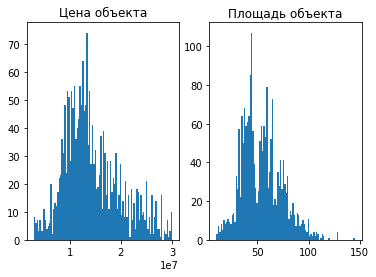

In [66]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(data['price'], bins=100)
axs[0].set_title('Цена объекта')
axs[1].hist(data['square'], bins=100)
axs[1].set_title('Площадь объекта')

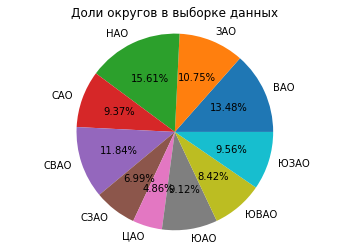

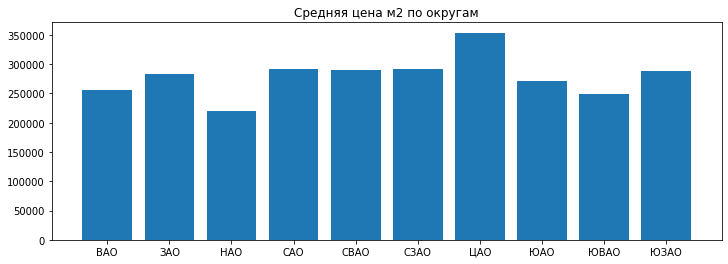

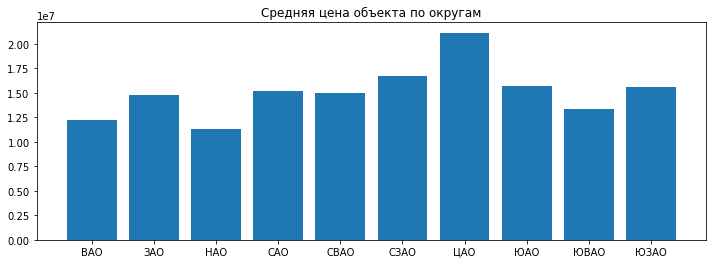

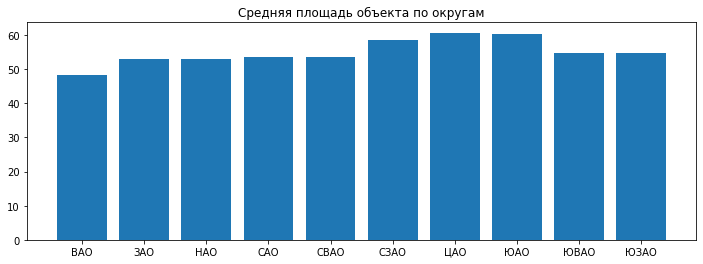

In [53]:
fig1, ax1 = plt.subplots() 
okrugs, texts, autotexts = ax1.pie(data['okrug'].value_counts().sort_index(ascending=True), labels = sorted(set(data['okrug'])), autopct='%1.2f%%')
ax1.axis('equal')
plt.title('Доли округов в выборке данных')

fig2, ax2 = plt.subplots()
ax2.bar(sorted(set(data['okrug'])),data.groupby('okrug').agg('mean')['price_per_m'].sort_index(ascending=True))
fig2.set_figwidth(12)
plt.title('Средняя цена м2 по округам')

fig3, ax3 = plt.subplots()
ax3.bar(sorted(set(data['okrug'])),data.groupby('okrug').agg('mean')['price'].sort_index(ascending=True))
fig3.set_figwidth(12)
plt.title('Средняя цена объекта по округам')

fig4, ax4 = plt.subplots()
ax4.bar(sorted(set(data['okrug'])),data.groupby('okrug').agg('mean')['square'].sort_index(ascending=True))
fig4.set_figwidth(12)
plt.title('Средняя площадь объекта по округам')
plt.show()

Удалим признаки которые будут бесполезны при обучении.
1. price_per_m - бесполезен, тк является комбинацией price и square.
2. address - бесполезен, тк является категориальным и принимает слишком много разных значений. Имел бы смысл при обучающей выборке покрупнее.
3. transport - признак, который был разобран на 2 новых.
4. room_sq - имеет слишком много пропусков, а так же принимает слишком много разных значений.

In [54]:
del data['price_per_m']
del data['address']
del data['transport']
del data['room_sq']

In [55]:
data.head()

,price,title,okrug,district,square,live_square,kitchen_square,etage,year,height,sanuzel,balcon,view,otdelka,all_etage,station,transport_time
0,9000000,1-комн. квартира,САО,р-н Аэропорт,35.9,19.0,19.0,1,1957,0.00,1 совмещенный,0,во двор,косметический,5,Сокол,18
1,16500000,3-комн. квартира,САО,р-н Аэропорт,64.0,43.7,7.1,6,1974,2.64,1 раздельный,2 балкона,во двор,косметический,12,Аэропорт,16
2,18500000,2-комн. квартира,САО,р-н Аэропорт,56.0,35.5,8.0,5,1958,0.00,1 совмещенный,1 балкон,во двор,косметический,5,Сокол,14
3,21000000,4-комн. квартира,ЦАО,р-н Красносельский,81.6,58.2,9.0,5,1927,2.95,1 раздельный,1 балкон,0,косметический,5,Комсомольская,10
4,18000000,2-комн. квартира,ЦАО,р-н Красносельский,60.0,37.0,8.0,2,1927,0.00,2 совмещенных,1 балкон,во двор,косметический,6,Комсомольская,10


Обратим внимание, что многие признаки являются категориальными и что для дальнейшего обучения их необходимо спроецировать в область вещественных значений. Для этого воспользуемся встроенным в библиотеку sklearn кодировщиком LabelEncoder().

In [56]:
features = ['title','okrug','district','sanuzel','balcon','view',
            'otdelka','station']
data_encoded = data.copy(deep=True)

def feature_encoding(data, features):
    le = LabelEncoder()
    for feature in features:
        le.fit(data[feature])
        data[feature] = le.transform(data[feature])
    return data

data_encoded = feature_encoding(data_encoded, features)
data_encoded.head()

,price,title,okrug,district,square,live_square,kitchen_square,etage,year,height,sanuzel,balcon,view,otdelka,all_etage,station,transport_time
0,9000000,1,3,9,35.9,19.0,19.0,1,1957,0.00,2,0,1,4,5,133,18
1,16500000,5,3,9,64.0,43.7,7.1,6,1974,2.64,1,4,1,4,12,6,16
2,18500000,3,3,9,56.0,35.5,8.0,5,1958,0.00,2,1,1,4,5,133,14
3,21000000,7,6,30,81.6,58.2,9.0,5,1927,2.95,1,1,0,4,5,58,10
4,18000000,3,6,30,60.0,37.0,8.0,2,1927,0.00,6,1,1,4,6,58,10


Теперь определим множество признаков для обучения (Х) и класс, который модель будет предсказывать (y).

In [57]:
X = data_encoded.loc[:, 'title':'transport_time']
y = data_encoded['price']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=1)

xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 42)

xgb_r.fit(X_train, y_train)
  
pred = xgb_r.predict(X_test)

[21:31:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


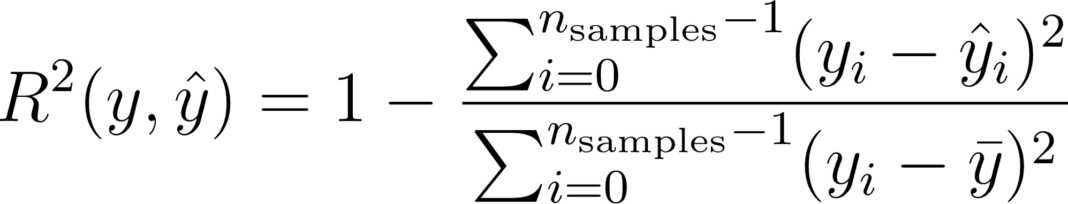

In [59]:
Image("r2.png")

In [60]:
print('R^2 score on training set: {:.3f}'.format(xgb_r.score(X_train,y_train)))
print('R^2 score on test set: {:.3f}'.format(xgb_r.score(X_test,y_test)))

R^2 score on training set: 0.905
R^2 score on test set: 0.774


Попробуем сделать предсказания для одного примера

In [61]:
check_example = {'title':["2-комн. квартира"],'okrug':["ЗАО"],
                 'district':["р-н Раменки"],'square':[55],
                 'live_square':[38],'kitchen_square':[12],'etage':[5],
                 'year':[2007],'height':[2.8],'sanuzel':["1 совмещенный"],
                 'balcon':["1 лоджия"],'view':["Во двор"],
                 'otdelka':["Дизайнерский"],'all_etage':[17],
                 'station':["Раменки"],'transport_time':[7]}
X_check = pd.DataFrame(check_example)
X_check = feature_encoding(pd.concat([data.loc[:,'title':'transport_time'],X_check]), features)[-1:]
y_pred = xgb_r.predict(X_check)
print(round(y_pred[0]),'руб','\n',round(y_pred[0])/check_example['square'][0],'руб/м2')

14855337.0 руб 
 270097.0363636364 руб/м2
